In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
!pwd

/content


In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

In [4]:
%cd /content/gdrive/MyDrive/Folder/

/content/gdrive/MyDrive/Folder


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Folder/"

In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

ham1000-segmentation-and-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
df_labels = pd.read_csv('/content/gdrive/MyDrive/Folder/GroundTruth.csv')
df_labels['image'] = df_labels['image'] +'.jpg'

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df_labels)):
    row= list(df_labels.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df_labels['label']= label_list
df_labels=df_labels.drop(labels, axis=1)
df_labels['label'].value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [30]:
data_directory = "/content/gdrive/MyDrive/Folder/data/"
os.listdir(data_directory)
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [31]:
image_directory = "/content/gdrive/MyDrive/Folder/images/"
def getPath(image_id):
  return image_directory + image_id + ".jpg"

In [32]:
data['path'] = data['image_id'].map(lambda x : getPath(x))

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   path          10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [34]:
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
data['age'] = data['age'].astype('int32')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     10015 non-null  object
 1   image_id      10015 non-null  object
 2   dx            10015 non-null  object
 3   dx_type       10015 non-null  object
 4   age           10015 non-null  int32 
 5   sex           10015 non-null  object
 6   localization  10015 non-null  object
 7   path          10015 non-null  object
dtypes: int32(1), object(7)
memory usage: 586.9+ KB


In [35]:
data['path'].head()

0    /content/gdrive/MyDrive/Folder/images/ISIC_002...
1    /content/gdrive/MyDrive/Folder/images/ISIC_002...
2    /content/gdrive/MyDrive/Folder/images/ISIC_002...
3    /content/gdrive/MyDrive/Folder/images/ISIC_002...
4    /content/gdrive/MyDrive/Folder/images/ISIC_003...
Name: path, dtype: object

In [36]:
df_labels.head()

,image,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [37]:
sdir=r'/content/gdrive/MyDrive/Folder//images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='cancer' # part of the name of the saved model
height=64  # image height
width=64   # image width
channels=3  # number of coloor channels
batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)

def scalar(img): # unused for efficientnet model
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet

df_gen=gen.flow_from_dataframe( df_labels, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 10015 validated image filenames belonging to 7 classes.


In [38]:
def show_image_samples(gen):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

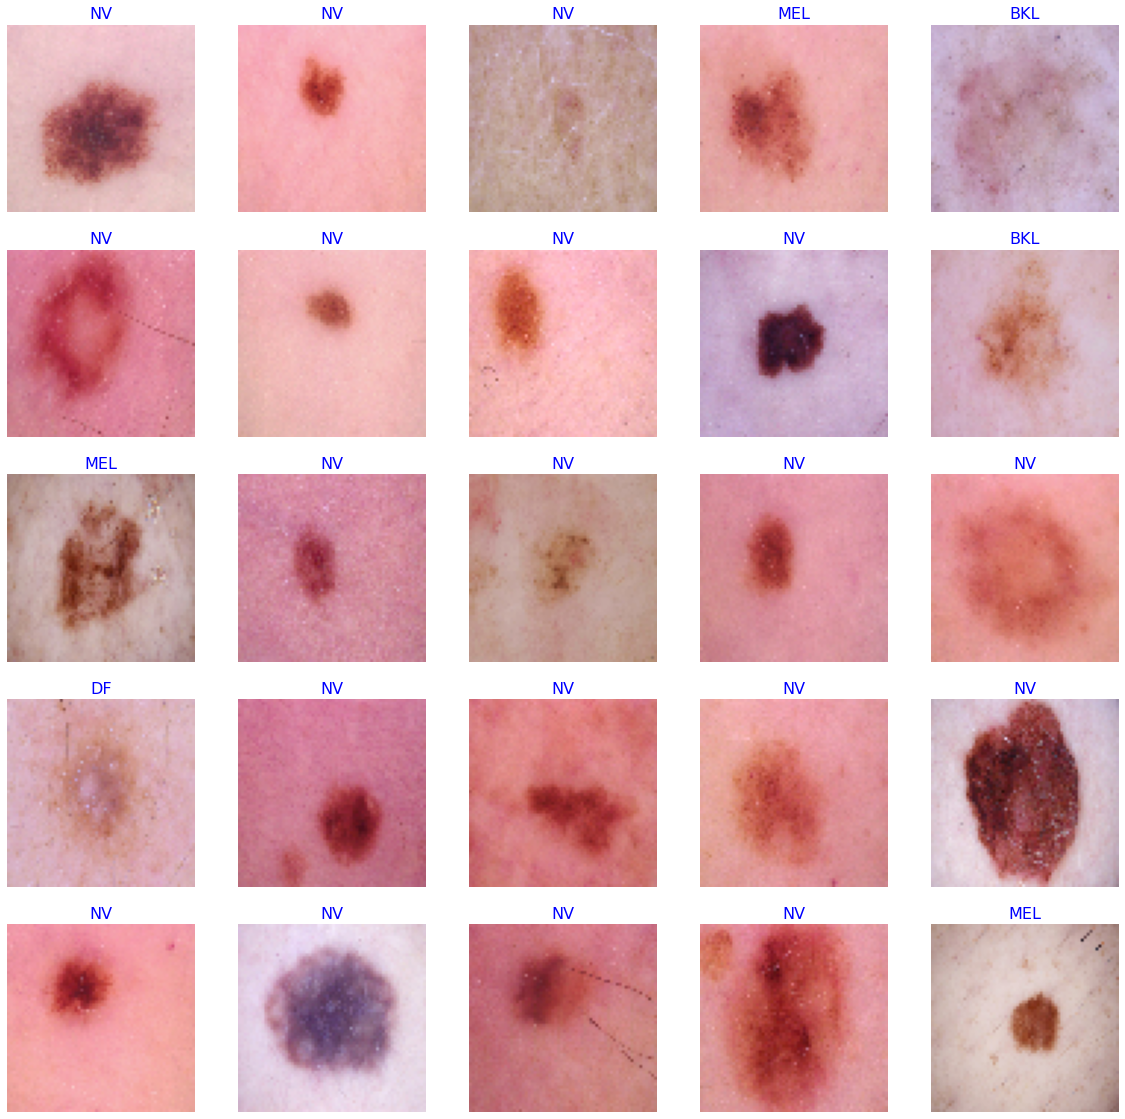

In [39]:
show_image_samples(df_gen)

In [41]:
import numpy as np 

In [42]:
X = np.load('/content/gdrive/MyDrive/Folder/images28_28.npy')
y = np.load('/content/gdrive/MyDrive/Folder/labels28_28.npy')

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
from sklearn.model_selection import train_test_split

tain_size=0.7
valid_size = 0.1
test_size = 0.2
valid_test_split = valid_size / test_size

train_df, valid_test_df = train_test_split(df_labels, train_size=tain_size, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(valid_test_df, train_size=valid_test_split, shuffle=True, random_state=42)

print(' train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
print (train_df.head())
print (train_df['label'].value_counts())

 train_df length:  7010   test_df length:  1503   valid_df length:  1502
                 image label
2399  ISIC_0026705.jpg    NV
8246  ISIC_0032552.jpg   MEL
8052  ISIC_0032358.jpg   BKL
5840  ISIC_0030146.jpg    NV
3540  ISIC_0027846.jpg   BCC
NV       4686
BKL       784
MEL       758
BCC       362
AKIEC     235
VASC      100
DF         85
Name: label, dtype: int64


In [45]:
train_gen=gen.flow_from_dataframe( train_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 7010 validated image filenames belonging to 7 classes.


In [46]:
valid_gen=gen.flow_from_dataframe(valid_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 1502 validated image filenames belonging to 7 classes.


SVM 

In [47]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l2

In [48]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(1,kernel_regularizer=l2(0.01),activation = "softmax"))

In [49]:
model.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
model.fit(x = train_gen, validation_data = valid_gen, epochs=10)

Epoch 1/10
176/176 [==============================] - 1591s 9s/step - loss: 3.4354 - accuracy: 0.1429 - val_loss: 3.4296 - val_accuracy: 0.1429
Epoch 2/10
176/176 [==============================] - 118s 670ms/step - loss: 3.4289 - accuracy: 0.1429 - val_loss: 3.4286 - val_accuracy: 0.1429
Epoch 3/10
176/176 [==============================] - 123s 697ms/step - loss: 3.4286 - accuracy: 0.1429 - val_loss: 3.4286 - val_accuracy: 0.1429
Epoch 4/10
176/176 [==============================] - 112s 636ms/step - loss: 3.4286 - accuracy: 0.1429 - val_loss: 3.4286 - val_accuracy: 0.1429
Epoch 5/10
176/176 [==============================] - 118s 668ms/step - loss: 3.4286 - accuracy: 0.1429 - val_loss: 3.4286 - val_accuracy: 0.1429
Epoch 6/10
176/176 [==============================] - 115s 653ms/step - loss: 3.4286 - accuracy: 0.1429 - val_loss: 3.4286 - val_accuracy: 0.1429
Epoch 7/10
176/176 [==============================] - 113s 642ms/step - loss: 3.4286 - accuracy: 0.1429 - val_loss: 3.4286 - v

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(1,kernel_regularizer=l2(0.01),activation = "linear"))

In [ ]:
model.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])
model.fit(x = train_gen, validation_data = valid_gen, epochs=10)

Epoch 1/10
176/176 [==============================] - 4702s 27s/step - loss: 2.3540 - accuracy: 0.8408 - val_loss: 0.3334 - val_accuracy: 0.8571
Epoch 2/10
176/176 [==============================] - 98s 554ms/step - loss: 0.3314 - accuracy: 0.8571 - val_loss: 0.3246 - val_accuracy: 0.8571
Epoch 3/10
176/176 [==============================] - 97s 549ms/step - loss: 0.3226 - accuracy: 0.8571 - val_loss: 0.3210 - val_accuracy: 0.8571
Epoch 4/10
176/176 [==============================] - 92s 522ms/step - loss: 0.3203 - accuracy: 0.8571 - val_loss: 0.3186 - val_accuracy: 0.8571
Epoch 5/10
176/176 [==============================] - 92s 521ms/step - loss: 0.3174 - accuracy: 0.8571 - val_loss: 0.3171 - val_accuracy: 0.8571
Epoch 6/10
176/176 [==============================] - 96s 543ms/step - loss: 0.3143 - accuracy: 0.8571 - val_loss: 0.3132 - val_accuracy: 0.8571
Epoch 7/10
176/176 [==============================] - 96s 544ms/step - loss: 0.3126 - accuracy: 0.8571 - val_loss: 0.3131 - val_ac

Logistics

In [ ]:
from sklearn.model_selection import train_test_split

tain_size=0.7
valid_size = 0.1
test_size = 0.2
valid_test_split = valid_size / test_size

train_df, valid_test_df = train_test_split(df_labels, train_size=tain_size, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(valid_test_df, train_size=valid_test_split, shuffle=True, random_state=42)

print(' train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
print (train_df.head())
print (train_df['label'].value_counts())

 train_df length:  7010   test_df length:  1503   valid_df length:  1502
                 image label
2399  ISIC_0026705.jpg    NV
8246  ISIC_0032552.jpg   MEL
8052  ISIC_0032358.jpg   BKL
5840  ISIC_0030146.jpg    NV
3540  ISIC_0027846.jpg   BCC
NV       4686
BKL       784
MEL       758
BCC       362
AKIEC     235
VASC      100
DF         85
Name: label, dtype: int64


In [ ]:
train_gen=gen.flow_from_dataframe( train_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 7010 validated image filenames belonging to 7 classes.


In [ ]:
valid_gen=gen.flow_from_dataframe(valid_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 1502 validated image filenames belonging to 7 classes.


In [ ]:
linear_model = tf.keras.Sequential([    
   keras.layers.Flatten(input_shape=(height, width, channels)),                                                                 
   keras.layers.Dense(7, activation = 'sigmoid')                                 
])
linear_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
linear_model.fit(train_gen, epochs=batch_size,  validation_data=valid_gen)

Epoch 1/40
176/176 [==============================] - 2412s 14s/step - loss: 75.3980 - accuracy: 0.5914 - val_loss: 38.2585 - val_accuracy: 0.6618
Epoch 2/40
176/176 [==============================] - 104s 590ms/step - loss: 36.8764 - accuracy: 0.6077 - val_loss: 57.4169 - val_accuracy: 0.2430
Epoch 3/40
176/176 [==============================] - 104s 590ms/step - loss: 42.0280 - accuracy: 0.6073 - val_loss: 43.4457 - val_accuracy: 0.6451
Epoch 4/40
176/176 [==============================] - 103s 587ms/step - loss: 35.6473 - accuracy: 0.6087 - val_loss: 30.7672 - val_accuracy: 0.6811
Epoch 5/40
176/176 [==============================] - 104s 589ms/step - loss: 48.9841 - accuracy: 0.5946 - val_loss: 40.7799 - val_accuracy: 0.5519
Epoch 6/40
176/176 [==============================] - 103s 588ms/step - loss: 38.4056 - accuracy: 0.6124 - val_loss: 56.4515 - val_accuracy: 0.5386
Epoch 7/40
176/176 [==============================] - 102s 581ms/step - loss: 31.1318 - accuracy: 0.6218 - val_lo

KeyboardInterrupt: ignored